In [26]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import time
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

# fix random generator seed (for reproducibility of results)
np.random.seed(42)
numpyro.set_host_device_count(4)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)


In [2]:
import datetime as dt
datadir = '/'.join(os.getcwd().split('/')[:-1])+"/2_Data/"
# Functions
@logger
def select_meter(df, meter=0): # Electricity = 0
    return df[df.meter==0].drop(columns=['meter'])

@logger
def drop_outliers(df, threshold=5000): # does this threshold makes sense?
    return df[df.meter_reading<threshold]

@logger
def to_datetime(df):
    df.timestamp = pd.to_datetime(df.timestamp)
    return df

def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [3]:
# Load data into DataFrames and reduce memory
df_meta_raw = pd.read_csv(datadir+'building_metadata.csv')
df_raw = pd.read_csv(datadir+'train.csv')
df_weather_raw = pd.read_csv(datadir+'weather_train.csv')

df = (df_raw.pipe(start_pipeline)
            .pipe(reduce_mem_usage)
            .pipe(select_meter) # only electricity
            #.pipe(drop_outliers) # check this threshold, we haven't done any visual check
            .pipe(to_datetime))
df_meta = (df_meta_raw.pipe(start_pipeline)
                      .pipe(reduce_mem_usage))
df_weather = (df_weather_raw.pipe(start_pipeline)
                           # .pipe(reduce_mem_usage)
                            .pipe(to_datetime))

start_pipeline took 0:00:00 secs, shape(20216100, 4)
Mem. usage decreased to 289.19 Mb (53.1% reduction)
reduce_mem_usage took 0:00:00 secs, shape(20216100, 4)
select_meter took 0:00:00 secs, shape(12060910, 3)
to_datetime took 0:00:00 secs, shape(12060910, 3)
start_pipeline took 0:00:00 secs, shape(1449, 6)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
reduce_mem_usage took 0:00:00 secs, shape(1449, 6)
start_pipeline took 0:00:00 secs, shape(139773, 9)
to_datetime took 0:00:00 secs, shape(139773, 9)


In [4]:
# Filter raw datasets to include only households
df_meta = df_meta[df_meta.primary_use.eq('Lodging/residential')]
hh_id = df_meta.building_id.unique()
df = df[df.building_id.isin(hh_id)]
hh_id2 = df.building_id.unique() # repeat because 2 ids are missing from df_meta
df_meta = df_meta[df_meta.building_id.isin(hh_id2)]
hh_site_id = df_meta.site_id.unique()
df_weather = df_weather[df_weather.site_id.isin(hh_site_id)]

In [5]:
df_weather.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,105006.000000,104954.000000,56950.000000,104942.000000,79239.000000,94545.000000,98989.000000,104702.000000
mean,6.808897,15.167207,1.525724,7.518587,0.747485,1016.313985,175.687420,3.431870
std,5.001241,10.262738,2.192687,9.528148,7.203729,7.214738,113.076102,2.293328
min,0.000000,-28.900000,0.000000,-31.700000,-1.000000,973.300000,0.000000,0.000000
25%,2.000000,8.300000,0.000000,0.600000,0.000000,1011.900000,80.000000,2.100000
50%,5.000000,15.600000,0.000000,8.300000,0.000000,1016.300000,180.000000,3.100000
75%,10.000000,22.800000,2.000000,14.400000,0.000000,1020.700000,280.000000,4.600000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,18.500000


In [6]:
df_weather.isna().sum()

site_id                   0
timestamp                 0
air_temperature          52
cloud_coverage        48056
dew_temperature          64
precip_depth_1_hr     25767
sea_level_pressure    10461
wind_direction         6017
wind_speed              304
dtype: int64

In [7]:
df_weather.groupby('site_id').sea_level_pressure.mean()

site_id
0     1017.988378
1     1015.989795
2     1011.679311
3     1017.938692
4     1016.887750
5             NaN
6     1017.527954
9     1016.625114
10    1015.668788
13    1015.895371
14    1016.377985
15    1016.980579
Name: sea_level_pressure, dtype: float64

In [8]:
def f_AR2(carry, inputs):
    noise_t = inputs
    beta1, beta2, z_prev1, z_prev2, tau = carry
    z_t = beta1 * z_prev1 + beta2 * z_prev2 + tau * noise_t
    z_prev1 = z_prev2
    z_prev2 = z_t
    return (beta1, beta2, z_prev1, z_prev2, tau), z_t

In [9]:
def model(T, T_forecast, obs=None, ix_mis=None, ix_obs=None):
    # Define priors over beta, tau, noises, sigma, z_1 (keep the shapes in mind)
    beta1 = numpyro.sample(name="beta1", fn=dist.Normal(loc=0., scale=1))
    beta2 = numpyro.sample(name="beta2", fn=dist.Normal(loc=0., scale=1))

    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=.1))
    noises = numpyro.sample("noises", fn=dist.Normal(0, 1.), sample_shape=(T+T_forecast-1,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev1 = numpyro.sample("z_prev1", dist.Normal(0, 3.0))
    z_prev2 = numpyro.sample("z_prev2", dist.Normal(0, 3.0))
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    carry, zs_exp = lax.scan(f_AR2, carry, noises, T+T_forecast-1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    # Sample the observed y (y_obs) and missing y (y_mis)
    numpyro.sample(name="y_mis", fn=dist.Normal(loc=z_collection[ix_mis], scale=sigma), obs=None)
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[ix_obs], scale=sigma), obs=obs[ix_obs])

In [45]:
# selecting_site
site_id = df_weather.site_id.sample(n=1).values[0]
# imputing sea pressure
X = df_weather[df_weather.site_id == site_id].sea_level_pressure.values

In [46]:
missing_idx = np.where(np.isnan(X))[0]
obs_ixd = np.where(~np.isnan(X))[0]
N_obs = len(obs_ixd)
N_mis = len(missing_idx)
N = N_obs + N_mis
print("N_obs:", N_obs)
print("N_mis:", N_mis)

N_obs: 8541
N_mis: 239


In [47]:
scaler = lambda x: (x - np.mean(x))/np.std(x)
X[obs_ixd] = scaler(X[obs_ixd])


In [ ]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000, num_chains=2)
mcmc.run(rng_key_, T=N, T_forecast=0, obs=X, ix_mis=missing_idx, ix_obs=obs_ixd)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

In [14]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta1     -0.85      0.00     -0.85     -0.85     -0.84      7.70      1.12
       beta2      1.84      0.00      1.84      1.83      1.85      8.33      1.07
   noises[0]      0.70      1.03      0.94     -0.77      2.30      3.76      1.54
   noises[1]     -1.77      0.44     -1.65     -2.46     -1.14      3.78      2.33
   noises[2]      0.39      0.81      0.39     -0.87      1.76      5.98      1.46
   noises[3]     -1.60      0.40     -1.54     -2.32     -1.10      3.19      2.28
   noises[4]     -3.07      0.17     -3.12     -3.29     -2.74      6.27      1.09
   noises[5]     -0.03      0.59     -0.11     -0.87      1.04     12.36      1.29
   noises[6]     -0.27      0.27     -0.28     -0.73      0.18     10.52      1.11
   noises[7]      0.33      0.85      0.53     -1.34      1.42      9.52      1.02
   noises[8]     -0.58      0.42     -0.55     -1.22      0.01      4.90      1.33
   

noises[3211]     -0.27      0.51     -0.28     -1.08      0.43      4.30      1.44
noises[3212]     -0.68      0.28     -0.68     -1.07     -0.21     11.94      1.17
noises[3213]      2.10      0.29      2.02      1.74      2.59      3.31      1.49
noises[3214]     -0.80      0.53     -0.83     -1.67     -0.04      3.50      1.48
noises[3215]      1.62      0.59      1.45      0.80      2.76      6.99      1.00
noises[3216]     -0.76      0.29     -0.80     -1.23     -0.33      5.76      1.84
noises[3217]      1.24      0.52      1.16      0.45      2.09      6.48      1.40
noises[3218]      1.66      0.60      1.63      0.66      2.68      7.98      1.21
noises[3219]     -1.59      0.12     -1.58     -1.79     -1.40      2.90      2.53
noises[3220]      0.90      0.70      0.92     -0.19      2.09     11.03      1.05
noises[3221]     -0.19      0.70     -0.16     -1.30      0.84      7.82      1.01
noises[3222]     -0.48      0.59     -0.40     -1.47      0.43     19.11      1.06
nois

noises[5529]      1.10      0.17      1.11      0.81      1.34      4.24      1.43
noises[5530]     -0.88      0.73     -0.81     -2.04      0.39      5.09      1.09
noises[5531]      0.62      0.34      0.67      0.06      1.14      5.04      1.12
noises[5532]     -1.00      0.36     -1.03     -1.57     -0.48     11.40      1.10
noises[5533]      0.71      0.38      0.65      0.15      1.32      6.96      1.30
noises[5534]     -0.08      0.40     -0.17     -0.53      0.81      3.60      1.52
noises[5535]      1.60      0.44      1.64      0.87      2.35      8.42      1.00
noises[5536]     -0.21      0.23     -0.18     -0.64      0.12     12.77      1.00
noises[5537]      0.35      0.52      0.43     -0.53      1.06      6.19      1.13
noises[5538]     -0.98      0.38     -0.95     -1.60     -0.38      3.14      1.91
noises[5539]     -0.21      0.59     -0.20     -0.99      0.77      7.67      1.23
noises[5540]      0.16      0.46      0.09     -0.48      1.04      8.94      1.25
nois

noises[7675]     -0.26      0.47     -0.29     -1.06      0.43      8.08      1.01
noises[7676]      0.18      0.99      0.55     -1.19      1.85      3.13      1.86
noises[7677]     -0.82      0.80     -0.94     -1.91      0.59      3.48      1.89
noises[7678]     -0.51      0.65     -0.56     -1.60      0.55      5.80      1.01
noises[7679]     -1.67      0.86     -1.75     -2.98     -0.18     12.77      1.03
noises[7680]      0.35      0.88      0.42     -0.90      1.94     10.96      1.12
noises[7681]      1.28      0.73      1.23     -0.02      2.37     11.14      1.13
noises[7682]     -0.31      0.53     -0.35     -1.22      0.53     13.71      1.05
noises[7683]      0.51      0.17      0.49      0.24      0.72      4.70      1.17
noises[7684]     -0.91      0.48     -1.05     -1.46      0.04      4.68      1.11
noises[7685]     -1.93      0.36     -1.90     -2.64     -1.46      4.53      1.47
noises[7686]     -0.37      0.15     -0.39     -0.58     -0.13      7.09      1.02
nois

Number of divergences: 1


In [17]:
hmc_samples = mcmc.get_samples()

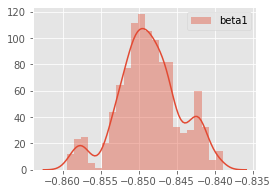

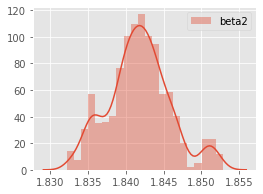

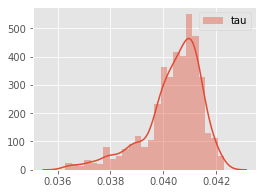

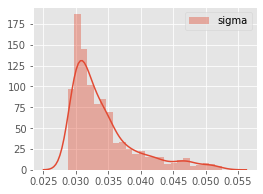

In [18]:
nodes = ["beta1", "beta2", "tau", "sigma"]
for node in nodes:
  plt.figure(figsize=(4,3))
  sns.distplot(hmc_samples[node], label=node)
  plt.legend()
  plt.show()

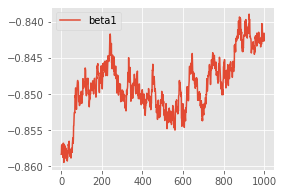

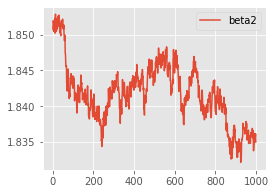

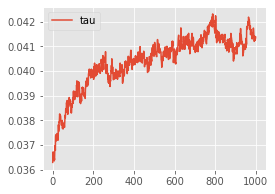

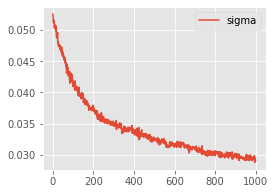

In [19]:
nodes = ["beta1", "beta2", "tau", "sigma"]
for node in nodes:
  plt.figure(figsize=(4,3))
  plt.plot(hmc_samples[node], label=node)
  plt.legend()
  plt.show()

In [20]:
# get mean and standard devitions for predictions
y_hat = hmc_samples["y_mis"].mean(axis=0)
y_std = hmc_samples["y_mis"].std(axis=0)

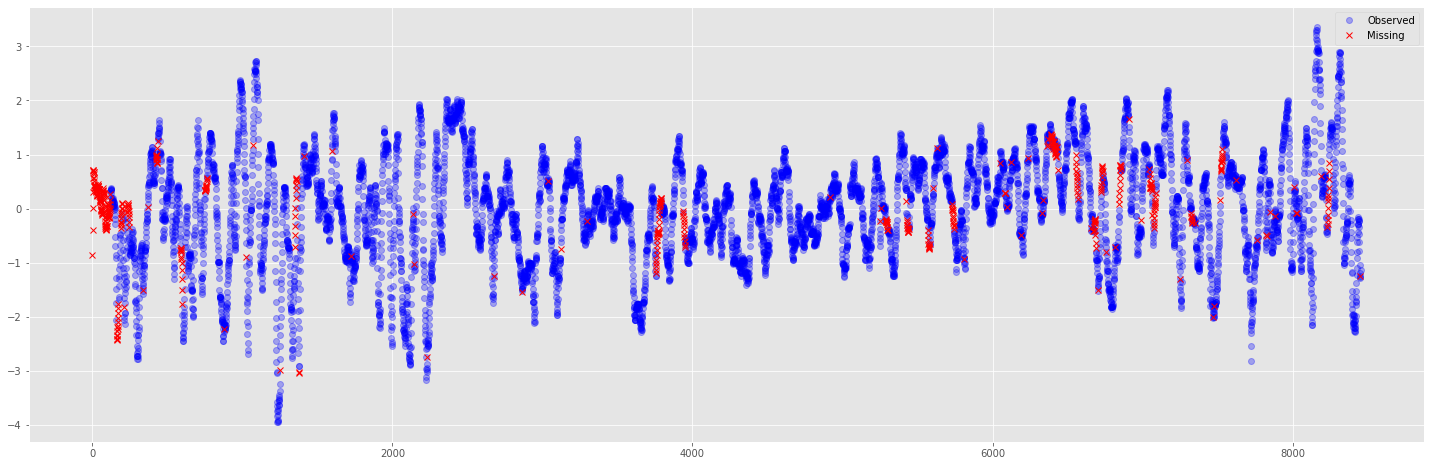

In [25]:
plt.figure(figsize=(25,8))
plt.plot(obs_ixd, X[obs_ixd], "bo", alpha=0.3)
#plt.plot(missing_idx, X[missing_idx], "bx")
plt.plot(missing_idx, y_hat, "rx")
plt.legend(["Observed", "Missing", "Imputed"]);